In [1]:
import pandas as pd
import numpy as np
from dateutil import parser
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve, f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

import catboost
from sklearn.preprocessing import LabelEncoder

In [5]:
train = pd.read_csv('train.csv')

In [8]:
test = pd.read_csv('test_bqCt9Pv.csv')

In [9]:
test.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,...,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,...,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


In [10]:
train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


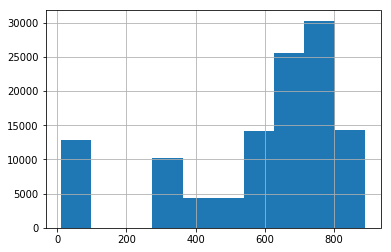

In [11]:
(train[train['PERFORM_CNS.SCORE']>0]['PERFORM_CNS.SCORE']).hist()

In [12]:
train_stat = train.describe().T

In [13]:
train_stat

,count,mean,std,min,25%,50%,75%,max
UniqueID,233154.0,535917.573376,6.831569e+04,417428.00,476786.25,535978.5,595039.75,6.710840e+05
disbursed_amount,233154.0,54356.993528,1.297131e+04,13320.00,47145.00,53803.0,60413.00,9.905720e+05
asset_cost,233154.0,75865.068144,1.894478e+04,37000.00,65717.00,70946.0,79201.75,1.628992e+06
ltv,233154.0,74.746530,1.145664e+01,10.03,68.88,76.8,83.67,9.500000e+01
branch_id,233154.0,72.936094,6.983499e+01,1.00,14.00,61.0,130.00,2.610000e+02
supplier_id,233154.0,19638.635035,3.491950e+03,10524.00,16535.00,20333.0,23000.00,2.480300e+04
manufacturer_id,233154.0,69.028054,2.214130e+01,45.00,48.00,86.0,86.00,1.560000e+02
Current_pincode_ID,233154.0,3396.880247,2.238148e+03,1.00,1511.00,2970.0,5677.00,7.345000e+03
State_ID,233154.0,7.262243,4.482230e+00,1.00,4.00,6.0,10.00,2.200000e+01
Employee_code_ID,233154.0,1549.477148,9.752613e+02,1.00,713.00,1451.0,2362.00,3.795000e+03


In [16]:
train.dtypes

UniqueID                                 int64
disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
branch_id                                int64
supplier_id                              int64
manufacturer_id                          int64
Current_pincode_ID                       int64
Date.of.Birth                           object
Employment.Type                         object
DisbursalDate                           object
State_ID                                 int64
Employee_code_ID                         int64
MobileNo_Avl_Flag                        int64
Aadhar_flag                              int64
PAN_flag                                 int64
VoterID_flag                             int64
Driving_flag                             int64
Passport_flag                            int64
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION           object
PRI.NO.OF.ACC

## EDA

UniqueID   233154


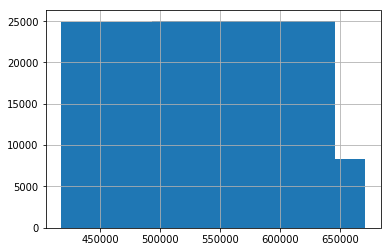

disbursed_amount   24565


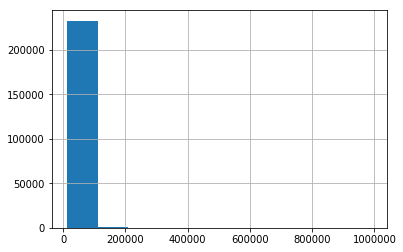

asset_cost   46252


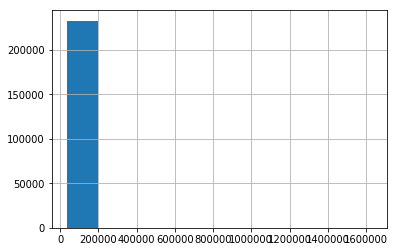

ltv   6579


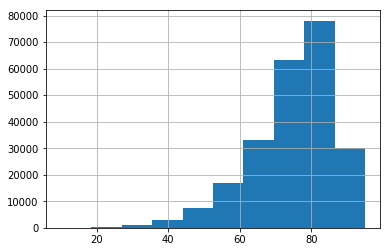

branch_id   82


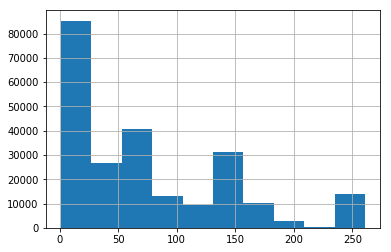

supplier_id   2953


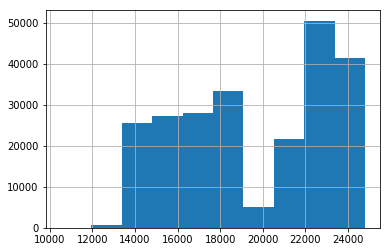

manufacturer_id   11


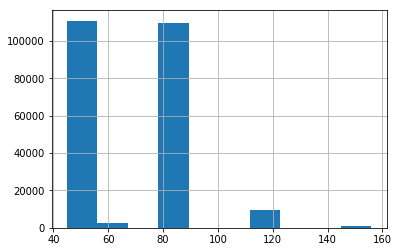

Current_pincode_ID   6698


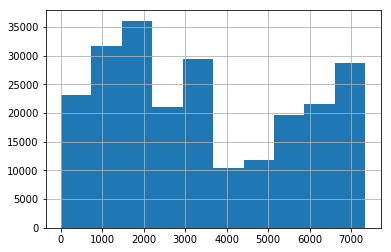

Date.of.Birth   15433
Employment.Type   2
DisbursalDate   84
State_ID   22


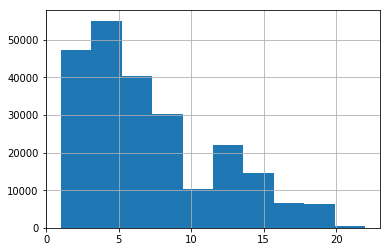

Employee_code_ID   3270


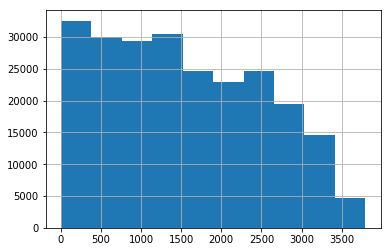

MobileNo_Avl_Flag   1


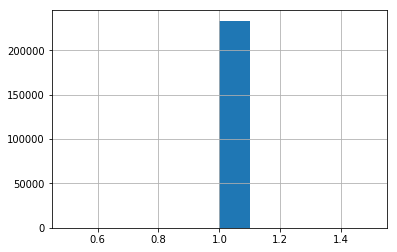

Aadhar_flag   2


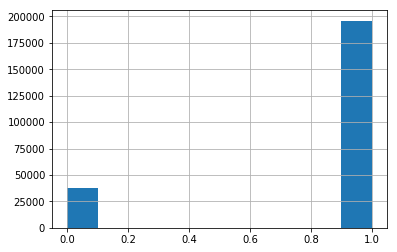

PAN_flag   2


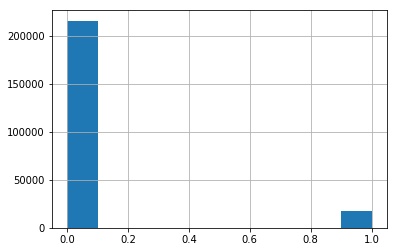

VoterID_flag   2


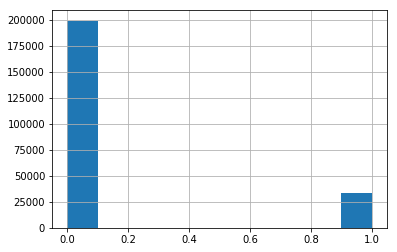

Driving_flag   2


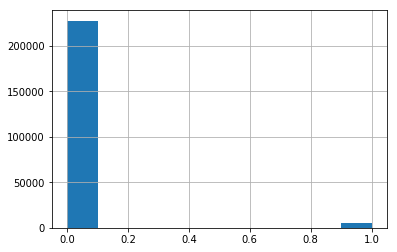

Passport_flag   2


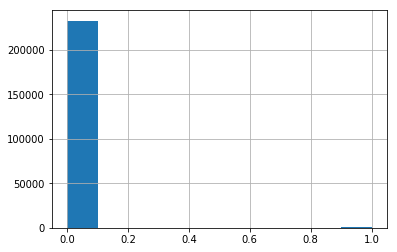

PERFORM_CNS.SCORE   573


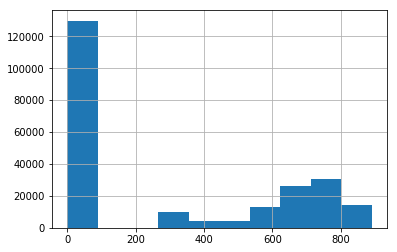

PERFORM_CNS.SCORE.DESCRIPTION   20
PRI.NO.OF.ACCTS   108


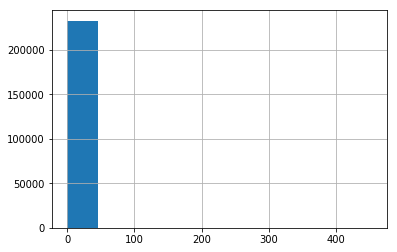

PRI.ACTIVE.ACCTS   40


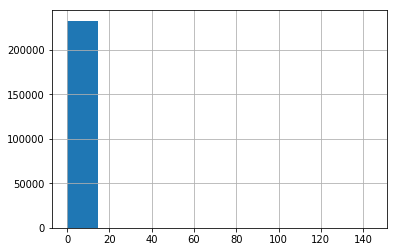

PRI.OVERDUE.ACCTS   22


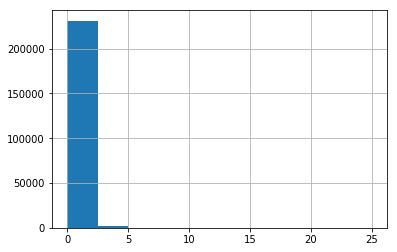

PRI.CURRENT.BALANCE   71341


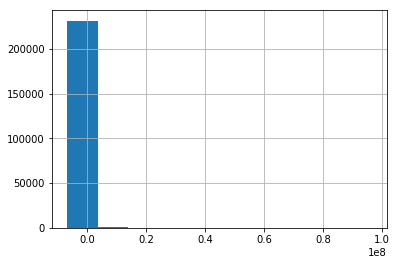

PRI.SANCTIONED.AMOUNT   44390


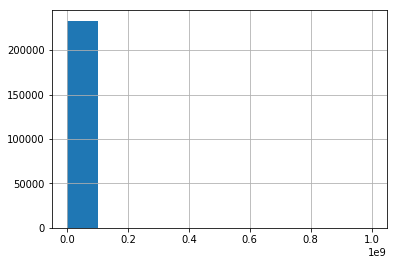

PRI.DISBURSED.AMOUNT   47909


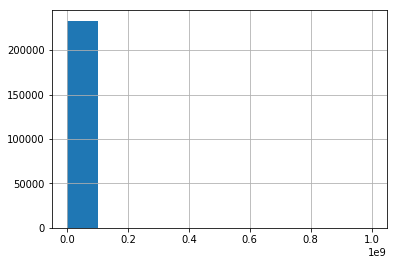

SEC.NO.OF.ACCTS   37


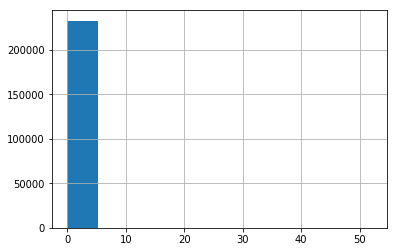

SEC.ACTIVE.ACCTS   23


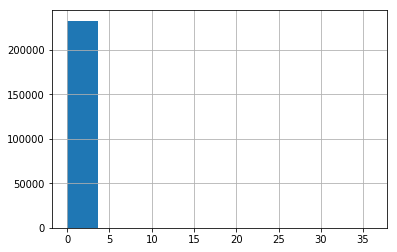

SEC.OVERDUE.ACCTS   9


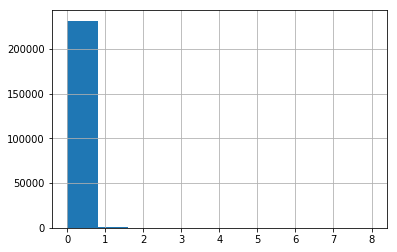

SEC.CURRENT.BALANCE   3246


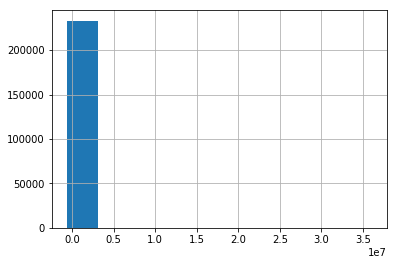

SEC.SANCTIONED.AMOUNT   2223


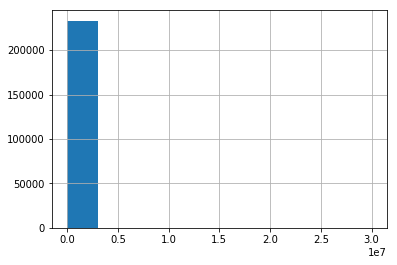

SEC.DISBURSED.AMOUNT   2553


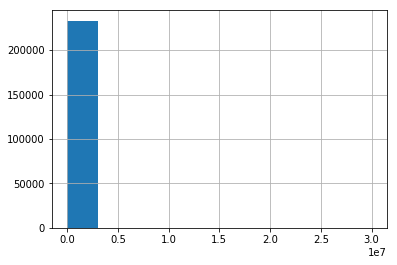

PRIMARY.INSTAL.AMT   28067


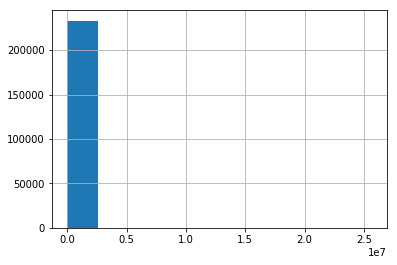

SEC.INSTAL.AMT   1918


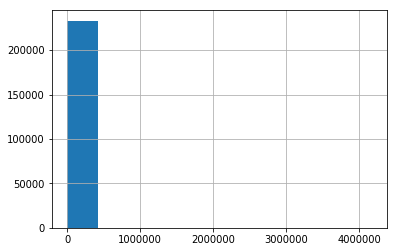

NEW.ACCTS.IN.LAST.SIX.MONTHS   26


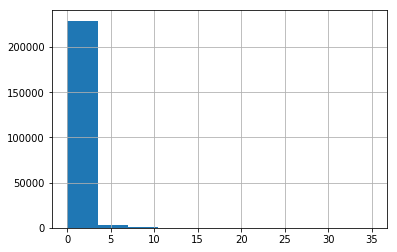

DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS   14


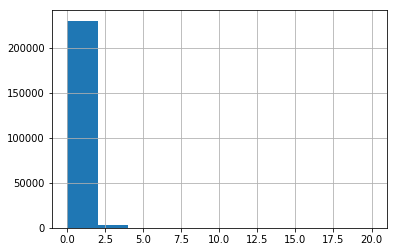

AVERAGE.ACCT.AGE   192
CREDIT.HISTORY.LENGTH   294
NO.OF_INQUIRIES   25


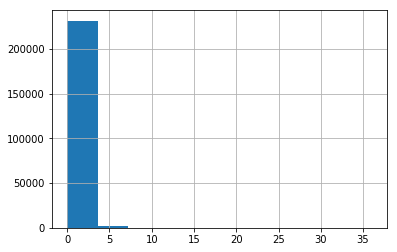

loan_default   2


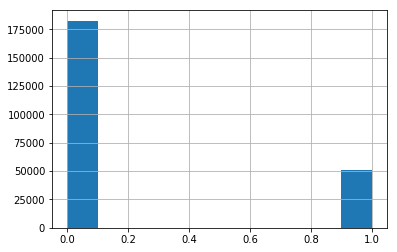

In [17]:
for i in train.columns:
    print(i,' ' ,train[i].nunique())
    if  ((train[i].dtype==int)|(train[i].dtype==float)) :
        train[i].hist()
        plt.show()

In [25]:
## all data features

In [26]:
train_data = train.loc[:,:'NO.OF_INQUIRIES']

In [27]:
train_data = pd.concat([train_data,test])

In [28]:
train_data['count'] = 1

In [29]:
employee = train_data.groupby(['Employee_code_ID'])['count','ltv','disbursed_amount', 'PERFORM_CNS.SCORE'].sum().reset_index()

employee.columns = ['Employee_code_ID', 'emp_count', 'emp_ltv','emp_disbursed_amount', 'emp_PERFORM_CNS.SCORE']

employee['emp_disbursed_amount'] = employee['emp_disbursed_amount']/train_data['disbursed_amount'].sum()
employee['emp_PERFORM_CNS.SCORE'] = employee['emp_PERFORM_CNS.SCORE']/employee['emp_count']


In [30]:
employee.head()

,Employee_code_ID,emp_count,emp_ltv,emp_disbursed_amount,emp_PERFORM_CNS.SCORE
0,1,106,8000.58,0.000282,367.792453
1,3,192,12896.98,0.000629,86.656250
2,4,96,7312.43,0.000275,280.656250
3,5,133,8343.33,0.000454,133.210526
4,7,221,16023.77,0.000599,249.402715


In [31]:
branch = train_data.groupby(['branch_id'])['count','ltv','disbursed_amount', 'PERFORM_CNS.SCORE'].sum().reset_index()

branch.columns = ['branch_id', 'branch_count', 'branch_ltv','branch_disbursed_amount', 'branch_PERFORM_CNS.SCORE']

branch['branch_disbursed_amount'] = branch['branch_disbursed_amount']/train_data['disbursed_amount'].sum()

branch['branch_PERFORM_CNS.SCORE'] = branch['branch_PERFORM_CNS.SCORE']/branch['branch_count']

In [32]:
pin = train_data.groupby(['Current_pincode_ID'])['count','ltv','disbursed_amount', 'PERFORM_CNS.SCORE'].sum().reset_index()

pin.columns = ['Current_pincode_ID', 'pin_count', 'pin_ltv','pin_disbursed_amount', 'pin_PERFORM_CNS.SCORE']

pin['pin_disbursed_amount'] = pin['pin_disbursed_amount']/train_data['disbursed_amount'].sum()

pin['pin_PERFORM_CNS.SCORE'] = pin['pin_PERFORM_CNS.SCORE']/pin['pin_count']

In [33]:
pin.columns

Index(['Current_pincode_ID', 'pin_count', 'pin_ltv', 'pin_disbursed_amount',
       'pin_PERFORM_CNS.SCORE'],
      dtype='object')

In [34]:
pin.head()

,Current_pincode_ID,pin_count,pin_ltv,pin_disbursed_amount,pin_PERFORM_CNS.SCORE
0,1,44,3356.62,0.000116,370.840909
1,2,118,9045.03,0.000319,362.813559
2,3,87,6804.11,0.000236,387.528736
3,4,153,11631.32,0.000387,406.150327
4,5,331,25177.85,0.000886,353.549849


In [35]:
supply = train_data.groupby(['supplier_id'])['count','ltv','disbursed_amount', 'PERFORM_CNS.SCORE'].sum().reset_index()

supply.columns = ['supplier_id', 'supply_count', 'supply_ltv','supply_disbursed_amount', 'supply_PERFORM_CNS.SCORE']

supply['supply_disbursed_amount'] = supply['supply_disbursed_amount']/train_data['disbursed_amount'].sum()

supply['supply_PERFORM_CNS.SCORE'] = supply['supply_PERFORM_CNS.SCORE']/supply['supply_count']



In [37]:
supply.columns

Index(['supplier_id', 'supply_count', 'supply_ltv', 'supply_disbursed_amount',
       'supply_PERFORM_CNS.SCORE'],
      dtype='object')

In [39]:
train.groupby('Employee_code_ID')['branch_id'].nunique().value_counts()

1    3109
2     161
Name: branch_id, dtype: int64

In [40]:
manufacturer = train_data.groupby(['manufacturer_id'])['count','ltv','disbursed_amount', 'PERFORM_CNS.SCORE'].sum().reset_index()

manufacturer.columns = ['manufacturer_id', 'manufacturer_count', 'manufacturer_ltv','manufacturer_disbursed_amount', 'manufacturer_PERFORM_CNS.SCORE']


manufacturer['manufacturer_disbursed_amount'] = manufacturer['manufacturer_disbursed_amount']/train_data['disbursed_amount'].sum()

manufacturer['manufacturer_PERFORM_CNS.SCORE'] = manufacturer['manufacturer_PERFORM_CNS.SCORE']/manufacturer['manufacturer_count']



In [41]:
emp_branch = train_data.groupby(['Employee_code_ID','branch_id'])['count','ltv','disbursed_amount', 'PERFORM_CNS.SCORE'].mean().reset_index()

emp_branch.columns = ['Employee_code_ID','branch_id', 'emp_branch_count', 'emp_branch_ltv','emp_branch_disbursed_amount', 'emp_branch_PERFORM_CNS.SCORE']

emp_branch2 = train_data.groupby(['branch_id'])['count', 'ltv','disbursed_amount', 'PERFORM_CNS.SCORE'].mean().reset_index()

emp_branch2.columns = ['branch_id', 'emp_branch_count', 'emp_branch_ltv','emp_branch_disbursed_amount', 'emp_branch_PERFORM_CNS.SCORE']
emp_branch_final = emp_branch.merge(emp_branch2,on = ['branch_id'] )


emp_branch_final['emp_branch_ltv_x'] = emp_branch_final['emp_branch_ltv_x']/emp_branch_final['emp_branch_ltv_y']
emp_branch_final['emp_branch_disbursed_amount_x'] = emp_branch_final['emp_branch_disbursed_amount_x']/emp_branch_final['emp_branch_disbursed_amount_y']
emp_branch_final['emp_branch_PERFORM_CNS.SCORE_x'] = emp_branch_final['emp_branch_PERFORM_CNS.SCORE_x']/emp_branch_final['emp_branch_PERFORM_CNS.SCORE_y']



In [42]:
emp_branch_final.tail()

,Employee_code_ID,branch_id,emp_branch_count_x,emp_branch_ltv_x,emp_branch_disbursed_amount_x,emp_branch_PERFORM_CNS.SCORE_x,emp_branch_count_y,emp_branch_ltv_y,emp_branch_disbursed_amount_y,emp_branch_PERFORM_CNS.SCORE_y
3617,3300,261,1.0,1.018188,0.881024,0.849037,1.0,79.574743,58599.246407,300.205339
3618,3364,261,1.0,1.022251,0.919931,1.090337,1.0,79.574743,58599.246407,300.205339
3619,3702,261,1.0,1.024382,0.855658,0.786646,1.0,79.574743,58599.246407,300.205339
3620,3800,261,1.0,0.934410,1.626098,0.912709,1.0,79.574743,58599.246407,300.205339
3621,3875,261,1.0,1.098615,0.871568,0.211189,1.0,79.574743,58599.246407,300.205339


In [43]:
emp_branch_final.columns

Index(['Employee_code_ID', 'branch_id', 'emp_branch_count_x',
       'emp_branch_ltv_x', 'emp_branch_disbursed_amount_x',
       'emp_branch_PERFORM_CNS.SCORE_x', 'emp_branch_count_y',
       'emp_branch_ltv_y', 'emp_branch_disbursed_amount_y',
       'emp_branch_PERFORM_CNS.SCORE_y'],
      dtype='object')

In [44]:
train['Employee_code_ID'].nunique()

3270

In [46]:
branch_pin = train_data.groupby(['branch_id','Current_pincode_ID'])['count'].sum().reset_index()
branch_count = train_data.groupby(['branch_id'])['count'].sum().reset_index()

branch_pin_final = branch_pin.merge(branch_count,on=['branch_id'])
branch_pin_final['count_x'] = 100*branch_pin_final['count_x']/ branch_pin_final['count_y']
branch_pin_final= branch_pin_final.drop('count_y', axis=1 )

In [47]:
branch_pin_final.head()

,branch_id,Current_pincode_ID,count_x
0,1,4906,0.023989
1,1,4907,0.143937
2,1,4908,0.035984
3,1,4909,0.071968
4,1,4910,0.191916


In [51]:
manufacturer.columns

Index(['manufacturer_id', 'manufacturer_count', 'manufacturer_ltv',
       'manufacturer_disbursed_amount', 'manufacturer_PERFORM_CNS.SCORE'],
      dtype='object')

## feature engineering and model training

In [338]:
def preprocessing(train):
          
    ## age preprocessing 
    train['DisbursalDate1'] = train['DisbursalDate'].apply(lambda x: x[:6]+ '20' + x[-2:])
    
    train['Date.of.Birth1'] = train['Date.of.Birth'].apply(lambda x: x[:6]+ '19' + x[-2:])
    
    train['age'] = train['DisbursalDate1'].apply(lambda x: int(x[-4:]) + float(x[3:5])/12 
    )   - train['Date.of.Birth1'].apply(lambda x: int(x[-4:]) + float(x[3:5])/12 )
    
    train['history_len'] = train['CREDIT.HISTORY.LENGTH'].apply(lambda x: float(x.split(' ')[1][:-3])/12 
                                       ) + train['CREDIT.HISTORY.LENGTH'].apply(lambda x: int(x[0]) )
    train['account_age'] = train['AVERAGE.ACCT.AGE'].apply(lambda x: float(x.split(' ')[1][:-3])/12 
                                        ) + train['AVERAGE.ACCT.AGE'].apply(lambda x: int(x[0]) )
    
    train['day'] = train['DisbursalDate1'].apply(lambda x: x[:2]).astype(int)
    train['weekday'] = pd.to_datetime(train1['DisbursalDate1']).dt.weekday
    
    
    
    ## Interaction features
    train = train.fillna('unemployed')
    
    train['asset_value'] = train['disbursed_amount'] / train['ltv']
    
    train['age_score'] = train['PERFORM_CNS.SCORE'] / train['age']
    train.loc[(train['age_score'].isnull())|(train['age_score']==np.inf)|(train['age_score']==-np.inf),'age_score' ] = -1
 
    train['%history'] = train['account_age']/ train['history_len']
    
    train['%disbursed'] = train['PRI.DISBURSED.AMOUNT']/train['disbursed_amount']
    train['%overdue'] = train['PRI.OVERDUE.ACCTS']/train['PRI.ACTIVE.ACCTS']
    
    train['%default'] = train['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']/train['NEW.ACCTS.IN.LAST.SIX.MONTHS']
    
    train['%emi'] = train['PRIMARY.INSTAL.AMT']/train['PRI.CURRENT.BALANCE']
    train.loc[(train['%emi'].isnull())|(train['%emi']==np.inf),'%emi' ] = -1
                              
    train.loc[(train['%overdue'].isnull())|(train['%overdue']==np.inf)|(train['%default']==-np.inf),'%overdue' ] = -1
    train.loc[(train['%default'].isnull())|(train['%default']==np.inf)|(train['%default']==-np.inf),'%default' ] = -1
    
    train['PRI_amount%'] = train['PRI.DISBURSED.AMOUNT']/ train['PRI.SANCTIONED.AMOUNT']
    train.loc[(train['PRI_amount%'].isnull())|(train['PRI_amount%']==np.inf)|(train['PRI_amount%']==-np.inf),'PRI_amount%' ] = -1
    
    train['SEC_amount%'] = train['SEC.DISBURSED.AMOUNT']/ train['SEC.SANCTIONED.AMOUNT']
    train.loc[(train['SEC_amount%'].isnull())|(train['SEC_amount%']==np.inf)|(train['PRI_amount%']==-np.inf),'SEC_amount%' ] = -1
    
    train['amount_score'] =  train['PERFORM_CNS.SCORE']/train['disbursed_amount']

    
    ##  encoding categorical variables
    train.loc[ train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored:'),
              'PERFORM_CNS.SCORE.DESCRIPTION' ] = 'Not Scored'
    
    train = pd.concat([train,pd.get_dummies(train['Employment.Type']) ], axis=1  )
    
    le = LabelEncoder()
    train['PERFORM_CNS.SCORE_code'] = le.fit_transform(train['PERFORM_CNS.SCORE.DESCRIPTION'])
    
    

    
    
    ## train and test combined data features
    train = train.merge(branch, on = ['branch_id'],how='left')

    train = train.merge(employee, on = ['Employee_code_ID'],how='left' )
    train = train.merge(pin, on = ['Current_pincode_ID'],how='left' )
    train = train.merge(supply, on = ['supplier_id'],how='left' )
    train = train.merge(emp_branch_final, on = ['Employee_code_ID', 'branch_id'],how='left' )
    train = train.merge(branch_pin_final, on = ['Current_pincode_ID', 'branch_id'],how='left' )
    train = train.merge(manufacturer, on = ['manufacturer_id'],how='left' )
    
   
     
    ## featrure transformation          
    train['asset_value_log'] = np.log(train['asset_value'])    
    train['asset_cost_log'] = np.log(train['asset_cost']) 
    
    train['disbursed_amount_log'] = np.log(train['disbursed_amount'])
    train['PERFORM_CNS.SCORE_log'] = np.log(train['PERFORM_CNS.SCORE'])
    
    train = train.merge(clusters, on=['UniqueID'])
    
    
    train = train.fillna(0)
    
    train = train.sort_values('UniqueID')
    
    
    
    return train

In [354]:
test1 = preprocessing(test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log


In [355]:
train1 = preprocessing(train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log


In [356]:
test1.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,manufacturer_PERFORM_CNS.SCORE,pin_ltv%,branch_ltv%,emp_ltv%,supply_ltv%,asset_value_log,asset_cost_log,disbursed_amount_log,PERFORM_CNS.SCORE_log,cluster
21229,654115,46849,67700,73.86,3,16277,45,571,01-01-83,Self employed,...,265.231284,0.000802,0.000065,0.005531,0.001148,6.452514,11.122841,10.754685,-inf,5
112,654116,41394,64286,66.89,34,18680,45,1027,27-12-96,Self employed,...,265.231284,0.019071,0.000083,0.007985,0.002528,6.427842,11.071097,10.630891,-inf,5
19289,654117,71123,99175,73.10,20,24312,49,6254,03-06-96,Salaried,...,234.294829,0.040619,0.000170,0.006229,0.026638,6.880338,11.504641,11.172166,-inf,1
2946,654118,76151,103490,77.30,10,23576,45,5697,01-01-83,Self employed,...,265.231284,0.004083,0.000194,0.006005,0.012380,6.892780,11.547230,11.240473,-inf,1
20554,654119,48445,72875,67.65,65,17752,51,6814,15-07-87,Self employed,...,292.977887,0.001865,0.000212,0.013354,0.004805,6.573837,11.196501,10.788184,-inf,1


In [357]:
features= ['disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
        'supplier_id', 'manufacturer_id', 'Current_pincode_ID',  'State_ID', 'Employee_code_ID',
         'Aadhar_flag', 'count_x',
         'PERFORM_CNS.SCORE',
         'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
        'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
        'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS'
        , 'SEC.CURRENT.BALANCE', 'SEC_amount%',
        'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
        'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
         'NO.OF_INQUIRIES',
         'age',   'history_len', 'account_age', 'Salaried', 'Self employed',
        'asset_value', 
           'emp_count', 'emp_ltv', 'emp_disbursed_amount',
       'emp_PERFORM_CNS.SCORE', 'branch_count', 'branch_ltv', 'branch_disbursed_amount',
       'branch_PERFORM_CNS.SCORE', 'pin_count', 'pin_ltv', 'pin_disbursed_amount',
       'pin_PERFORM_CNS.SCORE', 'supply_count', 'supply_ltv', 'supply_disbursed_amount',
       'supply_PERFORM_CNS.SCORE', 
                  'emp_branch_ltv_x', 'emp_branch_disbursed_amount_x',
       'emp_branch_PERFORM_CNS.SCORE_x', 
            '%disbursed', '%emi', 'asset_value_log', 'asset_cost_log', 
          'disbursed_amount_log', 'PERFORM_CNS.SCORE_log', 'PRI_amount%', 'age_score', '%history', 'day' , 'weekday'
        
              ]


In [392]:
X = train1[features]
y = train1['loan_default']

In [393]:
X.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,Aadhar_flag,...,%emi,asset_value_log,asset_cost_log,disbursed_amount_log,PERFORM_CNS.SCORE_log,PRI_amount%,age_score,%history,day,weekday
28976,55013,64080,88.17,18,14234,86,2699,4,415,1,...,0.087420,6.436058,11.067888,10.915325,6.523562,1.000000,12.889590,0.750000,1,0
35766,72567,88919,83.78,13,18486,86,4608,8,730,1,...,1.556175,6.764071,11.395481,11.192266,5.950643,1.000000,9.721519,0.857143,1,0
194,49049,64217,77.39,34,15196,86,1050,6,1863,1,...,-1.000000,6.451718,11.070023,10.800575,-inf,-1.000000,0.000000,0.000000,1,0
7182,53503,76245,72.14,10,22842,86,5708,3,778,1,...,-1.000000,6.608884,11.241707,10.887493,-inf,-1.000000,0.000000,0.000000,1,0
208438,55559,65524,85.92,67,21308,86,1446,6,2963,1,...,0.008880,6.471784,11.090172,10.925201,6.580639,0.984948,25.597633,0.428571,1,0


In [394]:
X_test1 = test1[features]

In [395]:
X_test1.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,Aadhar_flag,...,%emi,asset_value_log,asset_cost_log,disbursed_amount_log,PERFORM_CNS.SCORE_log,PRI_amount%,age_score,%history,day,weekday
21229,46849,67700,73.86,3,16277,45,571,15,705,1,...,-1.0,6.452514,11.122841,10.754685,-inf,-1.0,0.0,0.0,3,1
112,41394,64286,66.89,34,18680,45,1027,6,1835,1,...,-1.0,6.427842,11.071097,10.630891,-inf,-1.0,0.0,0.0,3,0
19289,71123,99175,73.10,20,24312,49,6254,5,1623,1,...,-1.0,6.880338,11.504641,11.172166,-inf,-1.0,0.0,0.0,3,1
2946,76151,103490,77.30,10,23576,45,5697,3,238,1,...,-1.0,6.892780,11.547230,11.240473,-inf,-1.0,0.0,0.0,3,4
20554,48445,72875,67.65,65,17752,51,6814,13,1783,0,...,-1.0,6.573837,11.196501,10.788184,-inf,-1.0,0.0,0.0,3,1


In [396]:
X['weekday'].unique()

array([0, 3, 6, 1, 4, 2, 5])

In [401]:
X_test1.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,Aadhar_flag,...,%emi,asset_value_log,asset_cost_log,disbursed_amount_log,PERFORM_CNS.SCORE_log,PRI_amount%,age_score,%history,day,weekday
21229,46849,67700,73.86,3,16277,45,571,15,705,1,...,-1.0,6.452514,11.122841,10.754685,-inf,-1.0,0.0,0.0,3,1
112,41394,64286,66.89,34,18680,45,1027,6,1835,1,...,-1.0,6.427842,11.071097,10.630891,-inf,-1.0,0.0,0.0,3,0
19289,71123,99175,73.10,20,24312,49,6254,5,1623,1,...,-1.0,6.880338,11.504641,11.172166,-inf,-1.0,0.0,0.0,3,1
2946,76151,103490,77.30,10,23576,45,5697,3,238,1,...,-1.0,6.892780,11.547230,11.240473,-inf,-1.0,0.0,0.0,3,4
20554,48445,72875,67.65,65,17752,51,6814,13,1783,0,...,-1.0,6.573837,11.196501,10.788184,-inf,-1.0,0.0,0.0,3,1


In [402]:
X_test1.columns

Index(['disbursed_amount', 'asset_cost', 'ltv', 'branch_id', 'supplier_id',
       'manufacturer_id', 'Current_pincode_ID', 'State_ID', 'Employee_code_ID',
       'Aadhar_flag', 'count_x', 'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
       'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.CURRENT.BALANCE', 'SEC_amount%', 'SEC.DISBURSED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES', 'age',
       'history_len', 'account_age', 'Salaried', 'Self employed',
       'asset_value', 'emp_count', 'emp_ltv', 'emp_disbursed_amount',
       'emp_PERFORM_CNS.SCORE', 'branch_count', 'branch_ltv',
       'branch_disbursed_amount', 'branch_PERFORM_CNS.SCORE', 'pin_count',
       'pin_ltv', 'pin_disbursed_amount', 'pin_PERFORM_CNS.SCORE',
       'supply_count', 'supply_ltv', 'supply_disbursed_amount',
 

## All data model

In [404]:
rf = catboost.CatBoostClassifier(cat_features= [3,6,7,8,62],  max_depth=5, reg_lambda=3,
                                   verbose=True )
   

X_train = X.copy()
y_train = y.copy()


rf.fit(X_train, y_train)
print('train score = ', rf.score(X_train, y_train))
print('train_roc = ', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]) )
#print(pd.DataFrame([rf.feature_importances_, X_train.columns]).T.sort_values(0,ascending=False) )
test_final = test1[['UniqueID']]
test_final['loan_default'] = rf.predict_proba(X_test1)[:,1]

X_train['loan_default1'] = rf.predict_proba(X_train)[:,1]
X_test1['loan_default1'] = rf.predict_proba(X_test1)[:,1]





0:	learn: 0.6811518	total: 150ms	remaining: 2m 29s
1:	learn: 0.6699425	total: 263ms	remaining: 2m 11s
2:	learn: 0.6594409	total: 363ms	remaining: 2m
3:	learn: 0.6496220	total: 450ms	remaining: 1m 52s
4:	learn: 0.6404102	total: 565ms	remaining: 1m 52s
5:	learn: 0.6317888	total: 669ms	remaining: 1m 50s
6:	learn: 0.6236964	total: 783ms	remaining: 1m 51s
7:	learn: 0.6161433	total: 912ms	remaining: 1m 53s
8:	learn: 0.6090830	total: 1.04s	remaining: 1m 54s
9:	learn: 0.6024763	total: 1.15s	remaining: 1m 53s
10:	learn: 0.5963614	total: 1.28s	remaining: 1m 55s
11:	learn: 0.5905614	total: 1.4s	remaining: 1m 55s
12:	learn: 0.5851612	total: 1.52s	remaining: 1m 55s
13:	learn: 0.5800756	total: 1.67s	remaining: 1m 57s
14:	learn: 0.5753301	total: 1.81s	remaining: 1m 58s
15:	learn: 0.5708776	total: 1.91s	remaining: 1m 57s
16:	learn: 0.5666979	total: 2.01s	remaining: 1m 56s
17:	learn: 0.5628110	total: 2.09s	remaining: 1m 53s
18:	learn: 0.5591581	total: 2.21s	remaining: 1m 53s
19:	learn: 0.5557538	total:

159:	learn: 0.4947524	total: 19.4s	remaining: 1m 41s
160:	learn: 0.4947228	total: 19.5s	remaining: 1m 41s
161:	learn: 0.4946962	total: 19.7s	remaining: 1m 41s
162:	learn: 0.4946616	total: 19.8s	remaining: 1m 41s
163:	learn: 0.4946202	total: 20s	remaining: 1m 41s
164:	learn: 0.4945962	total: 20.2s	remaining: 1m 42s
165:	learn: 0.4945575	total: 20.3s	remaining: 1m 42s
166:	learn: 0.4945295	total: 20.5s	remaining: 1m 42s
167:	learn: 0.4944947	total: 20.6s	remaining: 1m 41s
168:	learn: 0.4944623	total: 20.8s	remaining: 1m 42s
169:	learn: 0.4944334	total: 20.9s	remaining: 1m 42s
170:	learn: 0.4943933	total: 21.1s	remaining: 1m 42s
171:	learn: 0.4943624	total: 21.3s	remaining: 1m 42s
172:	learn: 0.4943421	total: 21.4s	remaining: 1m 42s
173:	learn: 0.4943087	total: 21.6s	remaining: 1m 42s
174:	learn: 0.4942756	total: 21.8s	remaining: 1m 42s
175:	learn: 0.4942507	total: 21.9s	remaining: 1m 42s
176:	learn: 0.4942096	total: 22.1s	remaining: 1m 42s
177:	learn: 0.4941810	total: 22.3s	remaining: 1m

315:	learn: 0.4912289	total: 40.4s	remaining: 1m 27s
316:	learn: 0.4912164	total: 40.5s	remaining: 1m 27s
317:	learn: 0.4912027	total: 40.7s	remaining: 1m 27s
318:	learn: 0.4911875	total: 40.8s	remaining: 1m 27s
319:	learn: 0.4911690	total: 40.9s	remaining: 1m 26s
320:	learn: 0.4911566	total: 41s	remaining: 1m 26s
321:	learn: 0.4911450	total: 41.1s	remaining: 1m 26s
322:	learn: 0.4911367	total: 41.2s	remaining: 1m 26s
323:	learn: 0.4911194	total: 41.4s	remaining: 1m 26s
324:	learn: 0.4911056	total: 41.5s	remaining: 1m 26s
325:	learn: 0.4910902	total: 41.5s	remaining: 1m 25s
326:	learn: 0.4910780	total: 41.7s	remaining: 1m 25s
327:	learn: 0.4910628	total: 41.8s	remaining: 1m 25s
328:	learn: 0.4910481	total: 41.9s	remaining: 1m 25s
329:	learn: 0.4910357	total: 42s	remaining: 1m 25s
330:	learn: 0.4910149	total: 42s	remaining: 1m 24s
331:	learn: 0.4910034	total: 42.2s	remaining: 1m 24s
332:	learn: 0.4909883	total: 42.3s	remaining: 1m 24s
333:	learn: 0.4909763	total: 42.4s	remaining: 1m 24s

472:	learn: 0.4892319	total: 55.6s	remaining: 1m 1s
473:	learn: 0.4892170	total: 55.7s	remaining: 1m 1s
474:	learn: 0.4892042	total: 55.8s	remaining: 1m 1s
475:	learn: 0.4891979	total: 55.9s	remaining: 1m 1s
476:	learn: 0.4891878	total: 56.1s	remaining: 1m 1s
477:	learn: 0.4891626	total: 56.2s	remaining: 1m 1s
478:	learn: 0.4891491	total: 56.4s	remaining: 1m 1s
479:	learn: 0.4891404	total: 56.5s	remaining: 1m 1s
480:	learn: 0.4891314	total: 56.6s	remaining: 1m 1s
481:	learn: 0.4891175	total: 56.8s	remaining: 1m 1s
482:	learn: 0.4891056	total: 56.9s	remaining: 1m
483:	learn: 0.4890950	total: 57.1s	remaining: 1m
484:	learn: 0.4890857	total: 57.2s	remaining: 1m
485:	learn: 0.4890791	total: 57.3s	remaining: 1m
486:	learn: 0.4890718	total: 57.4s	remaining: 1m
487:	learn: 0.4890616	total: 57.6s	remaining: 1m
488:	learn: 0.4890536	total: 57.7s	remaining: 1m
489:	learn: 0.4890456	total: 57.8s	remaining: 1m
490:	learn: 0.4890355	total: 57.9s	remaining: 1m
491:	learn: 0.4890234	total: 58s	remain

632:	learn: 0.4876917	total: 1m 12s	remaining: 42s
633:	learn: 0.4876817	total: 1m 12s	remaining: 41.8s
634:	learn: 0.4876747	total: 1m 12s	remaining: 41.7s
635:	learn: 0.4876639	total: 1m 12s	remaining: 41.6s
636:	learn: 0.4876543	total: 1m 12s	remaining: 41.5s
637:	learn: 0.4876469	total: 1m 12s	remaining: 41.3s
638:	learn: 0.4876387	total: 1m 12s	remaining: 41.2s
639:	learn: 0.4876306	total: 1m 13s	remaining: 41.1s
640:	learn: 0.4876250	total: 1m 13s	remaining: 41s
641:	learn: 0.4876148	total: 1m 13s	remaining: 40.9s
642:	learn: 0.4876087	total: 1m 13s	remaining: 40.7s
643:	learn: 0.4876015	total: 1m 13s	remaining: 40.6s
644:	learn: 0.4875930	total: 1m 13s	remaining: 40.5s
645:	learn: 0.4875856	total: 1m 13s	remaining: 40.4s
646:	learn: 0.4875780	total: 1m 13s	remaining: 40.3s
647:	learn: 0.4875692	total: 1m 13s	remaining: 40.1s
648:	learn: 0.4875599	total: 1m 14s	remaining: 40s
649:	learn: 0.4875515	total: 1m 14s	remaining: 39.9s
650:	learn: 0.4875471	total: 1m 14s	remaining: 39.8s

788:	learn: 0.4864673	total: 1m 27s	remaining: 23.5s
789:	learn: 0.4864489	total: 1m 27s	remaining: 23.4s
790:	learn: 0.4864428	total: 1m 28s	remaining: 23.3s
791:	learn: 0.4864367	total: 1m 28s	remaining: 23.2s
792:	learn: 0.4864210	total: 1m 28s	remaining: 23s
793:	learn: 0.4864113	total: 1m 28s	remaining: 22.9s
794:	learn: 0.4863963	total: 1m 28s	remaining: 22.8s
795:	learn: 0.4863886	total: 1m 28s	remaining: 22.7s
796:	learn: 0.4863799	total: 1m 28s	remaining: 22.6s
797:	learn: 0.4863722	total: 1m 28s	remaining: 22.5s
798:	learn: 0.4863670	total: 1m 28s	remaining: 22.4s
799:	learn: 0.4863592	total: 1m 28s	remaining: 22.2s
800:	learn: 0.4863509	total: 1m 29s	remaining: 22.1s
801:	learn: 0.4863426	total: 1m 29s	remaining: 22s
802:	learn: 0.4863329	total: 1m 29s	remaining: 21.9s
803:	learn: 0.4863247	total: 1m 29s	remaining: 21.8s
804:	learn: 0.4863209	total: 1m 29s	remaining: 21.7s
805:	learn: 0.4863110	total: 1m 29s	remaining: 21.6s
806:	learn: 0.4863062	total: 1m 29s	remaining: 21.

945:	learn: 0.4853158	total: 1m 43s	remaining: 5.9s
946:	learn: 0.4853091	total: 1m 43s	remaining: 5.79s
947:	learn: 0.4853055	total: 1m 43s	remaining: 5.68s
948:	learn: 0.4853017	total: 1m 43s	remaining: 5.57s
949:	learn: 0.4852929	total: 1m 43s	remaining: 5.46s
950:	learn: 0.4852851	total: 1m 43s	remaining: 5.35s
951:	learn: 0.4852721	total: 1m 43s	remaining: 5.24s
952:	learn: 0.4852678	total: 1m 44s	remaining: 5.13s
953:	learn: 0.4852643	total: 1m 44s	remaining: 5.02s
954:	learn: 0.4852582	total: 1m 44s	remaining: 4.91s
955:	learn: 0.4852499	total: 1m 44s	remaining: 4.8s
956:	learn: 0.4852440	total: 1m 44s	remaining: 4.69s
957:	learn: 0.4852403	total: 1m 44s	remaining: 4.58s
958:	learn: 0.4852327	total: 1m 44s	remaining: 4.47s
959:	learn: 0.4852249	total: 1m 44s	remaining: 4.37s
960:	learn: 0.4852193	total: 1m 44s	remaining: 4.26s
961:	learn: 0.4852127	total: 1m 44s	remaining: 4.15s
962:	learn: 0.4852087	total: 1m 45s	remaining: 4.04s
963:	learn: 0.4852026	total: 1m 45s	remaining: 3

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [406]:
# stacking another model adding previous models predictions as a feature
rf = catboost.CatBoostClassifier(cat_features= [3,6,7,8,62],  max_depth=5, reg_lambda=3,
                                    verbose=True )
print("-----")
rf.fit(X_train, y_train)
print('train score = ', rf.score(X_train, y_train))
print('train_roc = ', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]) )

test_final = test1[['UniqueID']]
test_final['loan_default'] = rf.predict_proba(X_test1)[:,1]



-----
0:	learn: 0.6785890	total: 93.5ms	remaining: 1m 33s
1:	learn: 0.6650370	total: 189ms	remaining: 1m 34s
2:	learn: 0.6525488	total: 281ms	remaining: 1m 33s
3:	learn: 0.6407477	total: 410ms	remaining: 1m 42s
4:	learn: 0.6297779	total: 521ms	remaining: 1m 43s
5:	learn: 0.6196725	total: 621ms	remaining: 1m 42s
6:	learn: 0.6101328	total: 759ms	remaining: 1m 47s
7:	learn: 0.6012320	total: 892ms	remaining: 1m 50s
8:	learn: 0.5929829	total: 1.04s	remaining: 1m 54s
9:	learn: 0.5853007	total: 1.17s	remaining: 1m 56s
10:	learn: 0.5781884	total: 1.29s	remaining: 1m 56s
11:	learn: 0.5715138	total: 1.38s	remaining: 1m 53s
12:	learn: 0.5653033	total: 1.49s	remaining: 1m 52s
13:	learn: 0.5595266	total: 1.57s	remaining: 1m 50s
14:	learn: 0.5542943	total: 1.7s	remaining: 1m 51s
15:	learn: 0.5493276	total: 1.83s	remaining: 1m 52s
16:	learn: 0.5446331	total: 1.96s	remaining: 1m 53s
17:	learn: 0.5404391	total: 2.09s	remaining: 1m 54s
18:	learn: 0.5365148	total: 2.21s	remaining: 1m 54s
19:	learn: 0.532

157:	learn: 0.4748967	total: 20.3s	remaining: 1m 47s
158:	learn: 0.4748690	total: 20.4s	remaining: 1m 47s
159:	learn: 0.4748487	total: 20.5s	remaining: 1m 47s
160:	learn: 0.4748291	total: 20.7s	remaining: 1m 47s
161:	learn: 0.4748059	total: 20.8s	remaining: 1m 47s
162:	learn: 0.4747885	total: 20.9s	remaining: 1m 47s
163:	learn: 0.4747645	total: 21.1s	remaining: 1m 47s
164:	learn: 0.4747482	total: 21.2s	remaining: 1m 47s
165:	learn: 0.4747266	total: 21.3s	remaining: 1m 47s
166:	learn: 0.4747053	total: 21.5s	remaining: 1m 47s
167:	learn: 0.4746905	total: 21.6s	remaining: 1m 46s
168:	learn: 0.4746735	total: 21.7s	remaining: 1m 46s
169:	learn: 0.4746556	total: 21.8s	remaining: 1m 46s
170:	learn: 0.4746413	total: 21.9s	remaining: 1m 46s
171:	learn: 0.4746257	total: 22.1s	remaining: 1m 46s
172:	learn: 0.4745967	total: 22.2s	remaining: 1m 45s
173:	learn: 0.4745772	total: 22.3s	remaining: 1m 45s
174:	learn: 0.4745620	total: 22.4s	remaining: 1m 45s
175:	learn: 0.4745449	total: 22.5s	remaining: 

313:	learn: 0.4722712	total: 38.9s	remaining: 1m 24s
314:	learn: 0.4722596	total: 39s	remaining: 1m 24s
315:	learn: 0.4722386	total: 39.1s	remaining: 1m 24s
316:	learn: 0.4722180	total: 39.2s	remaining: 1m 24s
317:	learn: 0.4722006	total: 39.3s	remaining: 1m 24s
318:	learn: 0.4721893	total: 39.5s	remaining: 1m 24s
319:	learn: 0.4721800	total: 39.6s	remaining: 1m 24s
320:	learn: 0.4721668	total: 39.7s	remaining: 1m 23s
321:	learn: 0.4721557	total: 39.8s	remaining: 1m 23s
322:	learn: 0.4721380	total: 39.9s	remaining: 1m 23s
323:	learn: 0.4721201	total: 40s	remaining: 1m 23s
324:	learn: 0.4721074	total: 40.1s	remaining: 1m 23s
325:	learn: 0.4720945	total: 40.3s	remaining: 1m 23s
326:	learn: 0.4720814	total: 40.4s	remaining: 1m 23s
327:	learn: 0.4720615	total: 40.5s	remaining: 1m 22s
328:	learn: 0.4720513	total: 40.6s	remaining: 1m 22s
329:	learn: 0.4720380	total: 40.7s	remaining: 1m 22s
330:	learn: 0.4720284	total: 40.8s	remaining: 1m 22s
331:	learn: 0.4720187	total: 41s	remaining: 1m 22s

471:	learn: 0.4703028	total: 56s	remaining: 1m 2s
472:	learn: 0.4702886	total: 56.1s	remaining: 1m 2s
473:	learn: 0.4702783	total: 56.2s	remaining: 1m 2s
474:	learn: 0.4702706	total: 56.3s	remaining: 1m 2s
475:	learn: 0.4702605	total: 56.4s	remaining: 1m 2s
476:	learn: 0.4702506	total: 56.5s	remaining: 1m 1s
477:	learn: 0.4702429	total: 56.6s	remaining: 1m 1s
478:	learn: 0.4702342	total: 56.7s	remaining: 1m 1s
479:	learn: 0.4702215	total: 56.8s	remaining: 1m 1s
480:	learn: 0.4702126	total: 57s	remaining: 1m 1s
481:	learn: 0.4702014	total: 57.1s	remaining: 1m 1s
482:	learn: 0.4701924	total: 57.2s	remaining: 1m 1s
483:	learn: 0.4701784	total: 57.3s	remaining: 1m 1s
484:	learn: 0.4701650	total: 57.4s	remaining: 1m
485:	learn: 0.4701546	total: 57.5s	remaining: 1m
486:	learn: 0.4701448	total: 57.6s	remaining: 1m
487:	learn: 0.4701315	total: 57.7s	remaining: 1m
488:	learn: 0.4701234	total: 57.8s	remaining: 1m
489:	learn: 0.4701105	total: 57.9s	remaining: 1m
490:	learn: 0.4700998	total: 58s	r

631:	learn: 0.4686290	total: 1m 12s	remaining: 42.3s
632:	learn: 0.4686157	total: 1m 12s	remaining: 42.2s
633:	learn: 0.4686062	total: 1m 12s	remaining: 42s
634:	learn: 0.4685979	total: 1m 12s	remaining: 41.9s
635:	learn: 0.4685884	total: 1m 13s	remaining: 41.8s
636:	learn: 0.4685812	total: 1m 13s	remaining: 41.7s
637:	learn: 0.4685700	total: 1m 13s	remaining: 41.5s
638:	learn: 0.4685622	total: 1m 13s	remaining: 41.4s
639:	learn: 0.4685536	total: 1m 13s	remaining: 41.3s
640:	learn: 0.4685433	total: 1m 13s	remaining: 41.2s
641:	learn: 0.4685339	total: 1m 13s	remaining: 41.1s
642:	learn: 0.4685207	total: 1m 13s	remaining: 41s
643:	learn: 0.4685096	total: 1m 13s	remaining: 40.8s
644:	learn: 0.4684973	total: 1m 13s	remaining: 40.7s
645:	learn: 0.4684871	total: 1m 14s	remaining: 40.6s
646:	learn: 0.4684724	total: 1m 14s	remaining: 40.5s
647:	learn: 0.4684650	total: 1m 14s	remaining: 40.4s
648:	learn: 0.4684521	total: 1m 14s	remaining: 40.2s
649:	learn: 0.4684444	total: 1m 14s	remaining: 40.

787:	learn: 0.4671706	total: 1m 29s	remaining: 24s
788:	learn: 0.4671630	total: 1m 29s	remaining: 23.9s
789:	learn: 0.4671566	total: 1m 29s	remaining: 23.8s
790:	learn: 0.4671492	total: 1m 29s	remaining: 23.7s
791:	learn: 0.4671386	total: 1m 29s	remaining: 23.6s
792:	learn: 0.4671319	total: 1m 29s	remaining: 23.5s
793:	learn: 0.4671231	total: 1m 30s	remaining: 23.4s
794:	learn: 0.4671176	total: 1m 30s	remaining: 23.3s
795:	learn: 0.4671038	total: 1m 30s	remaining: 23.1s
796:	learn: 0.4670952	total: 1m 30s	remaining: 23s
797:	learn: 0.4670886	total: 1m 30s	remaining: 22.9s
798:	learn: 0.4670790	total: 1m 30s	remaining: 22.8s
799:	learn: 0.4670726	total: 1m 30s	remaining: 22.7s
800:	learn: 0.4670630	total: 1m 30s	remaining: 22.6s
801:	learn: 0.4670566	total: 1m 31s	remaining: 22.5s
802:	learn: 0.4670465	total: 1m 31s	remaining: 22.4s
803:	learn: 0.4670376	total: 1m 31s	remaining: 22.2s
804:	learn: 0.4670286	total: 1m 31s	remaining: 22.1s
805:	learn: 0.4670216	total: 1m 31s	remaining: 22s

944:	learn: 0.4658627	total: 1m 46s	remaining: 6.22s
945:	learn: 0.4658560	total: 1m 47s	remaining: 6.11s
946:	learn: 0.4658514	total: 1m 47s	remaining: 6s
947:	learn: 0.4658466	total: 1m 47s	remaining: 5.88s
948:	learn: 0.4658395	total: 1m 47s	remaining: 5.77s
949:	learn: 0.4658291	total: 1m 47s	remaining: 5.66s
950:	learn: 0.4658224	total: 1m 47s	remaining: 5.54s
951:	learn: 0.4658149	total: 1m 47s	remaining: 5.43s
952:	learn: 0.4658044	total: 1m 47s	remaining: 5.32s
953:	learn: 0.4657965	total: 1m 47s	remaining: 5.2s
954:	learn: 0.4657889	total: 1m 48s	remaining: 5.09s
955:	learn: 0.4657800	total: 1m 48s	remaining: 4.98s
956:	learn: 0.4657711	total: 1m 48s	remaining: 4.87s
957:	learn: 0.4657650	total: 1m 48s	remaining: 4.75s
958:	learn: 0.4657595	total: 1m 48s	remaining: 4.64s
959:	learn: 0.4657554	total: 1m 48s	remaining: 4.53s
960:	learn: 0.4657493	total: 1m 48s	remaining: 4.41s
961:	learn: 0.4657448	total: 1m 48s	remaining: 4.3s
962:	learn: 0.4657390	total: 1m 48s	remaining: 4.19

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [374]:
test_final.head()

,UniqueID,loan_default
21229,654115,0.134535
112,654116,0.182773
19289,654117,0.269199
2946,654118,0.337156
20554,654119,0.284833


In [409]:
test_final[test_final['loan_default']>0.5].shape #2609

(2609, 2)

In [408]:
test_final.to_csv('test_submition.csv', index=False)

## CV 5 Model

In [391]:
#cross validation check
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=123)
skf.get_n_splits(X, y)
l = []
feat = []
roc = []

for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)

    X_train, X_test = X[X.index.isin(train_index) ], X[X.index.isin(test_index) ]
    y_train, y_test = y[y.index.isin(train_index) ], y[y.index.isin(test_index) ]
    
    #rf = lightgbm.LGBMClassifier(max_depth=3) 
   
    rf = catboost.CatBoostClassifier(cat_features= [3,6,7,8,62],  max_depth=5, reg_lambda=3,
                                     verbose=True )
   
    #rf = xgb.XGBClassifier(scale_pos_weight=1.5,max_delta_step=0.5, max_depth=4, colsample_bytree=0.7,
      #                     subsample=0.95, learning_rate=0.15, reg_lambda=0.95,reg_alpha=0.05, n_estimators=80,n_jobs=-1)
   
    
    print("-----")
    rf.fit(X_train, y_train)
    print('train score = ', rf.score(X_train, y_train))
    print('val score = ', rf.score(X_test, y_test))
    print('train_roc = ', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]) )
    print('roc = ', roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
    print(pd.DataFrame([rf.feature_importances_, X_train.columns]).T.sort_values(0,ascending=False) )
    test_final = test1[['UniqueID']]
    test_final['loan_default'] = rf.predict_proba(X_test1)[:,1]
    X_test1['loan_default'] = rf.predict_proba(X_test1)[:,1]
    
    l.append(test_final)
    feat.append(pd.DataFrame([rf.feature_importances_, X_train.columns]).T.sort_values(0,ascending=False) )
    roc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]) )
    # roc 66.93 best
    break
    # 3.6
    

-----
0:	learn: 0.6814644	total: 93ms	remaining: 1m 32s
1:	learn: 0.6705473	total: 189ms	remaining: 1m 34s
2:	learn: 0.6603177	total: 276ms	remaining: 1m 31s
3:	learn: 0.6507395	total: 369ms	remaining: 1m 31s
4:	learn: 0.6417309	total: 451ms	remaining: 1m 29s
5:	learn: 0.6333664	total: 537ms	remaining: 1m 28s
6:	learn: 0.6255528	total: 629ms	remaining: 1m 29s
7:	learn: 0.6182682	total: 729ms	remaining: 1m 30s
8:	learn: 0.6113800	total: 819ms	remaining: 1m 30s
9:	learn: 0.6049591	total: 900ms	remaining: 1m 29s
10:	learn: 0.5989439	total: 996ms	remaining: 1m 29s
11:	learn: 0.5932988	total: 1.1s	remaining: 1m 30s
12:	learn: 0.5879972	total: 1.2s	remaining: 1m 30s
13:	learn: 0.5831087	total: 1.29s	remaining: 1m 30s
14:	learn: 0.5785086	total: 1.39s	remaining: 1m 31s
15:	learn: 0.5741655	total: 1.49s	remaining: 1m 31s
16:	learn: 0.5701537	total: 1.6s	remaining: 1m 32s
17:	learn: 0.5663741	total: 1.7s	remaining: 1m 32s
18:	learn: 0.5628154	total: 1.79s	remaining: 1m 32s
19:	learn: 0.5594895	

158:	learn: 0.4998282	total: 13.6s	remaining: 1m 11s
159:	learn: 0.4997818	total: 13.7s	remaining: 1m 11s
160:	learn: 0.4997507	total: 13.7s	remaining: 1m 11s
161:	learn: 0.4997099	total: 13.8s	remaining: 1m 11s
162:	learn: 0.4996779	total: 13.9s	remaining: 1m 11s
163:	learn: 0.4996422	total: 14s	remaining: 1m 11s
164:	learn: 0.4995959	total: 14s	remaining: 1m 11s
165:	learn: 0.4995630	total: 14.1s	remaining: 1m 10s
166:	learn: 0.4995306	total: 14.2s	remaining: 1m 10s
167:	learn: 0.4994979	total: 14.3s	remaining: 1m 10s
168:	learn: 0.4994599	total: 14.4s	remaining: 1m 10s
169:	learn: 0.4994315	total: 14.4s	remaining: 1m 10s
170:	learn: 0.4994005	total: 14.5s	remaining: 1m 10s
171:	learn: 0.4993586	total: 14.6s	remaining: 1m 10s
172:	learn: 0.4993302	total: 14.7s	remaining: 1m 10s
173:	learn: 0.4992885	total: 14.7s	remaining: 1m 9s
174:	learn: 0.4992497	total: 14.8s	remaining: 1m 9s
175:	learn: 0.4992086	total: 14.9s	remaining: 1m 9s
176:	learn: 0.4991798	total: 15s	remaining: 1m 9s
177

319:	learn: 0.4958601	total: 26.5s	remaining: 56.2s
320:	learn: 0.4958430	total: 26.5s	remaining: 56.1s
321:	learn: 0.4958128	total: 26.6s	remaining: 56s
322:	learn: 0.4957907	total: 26.7s	remaining: 56s
323:	learn: 0.4957716	total: 26.8s	remaining: 55.9s
324:	learn: 0.4957447	total: 26.9s	remaining: 55.8s
325:	learn: 0.4957294	total: 26.9s	remaining: 55.7s
326:	learn: 0.4957069	total: 27s	remaining: 55.6s
327:	learn: 0.4956948	total: 27.1s	remaining: 55.5s
328:	learn: 0.4956827	total: 27.2s	remaining: 55.4s
329:	learn: 0.4956651	total: 27.2s	remaining: 55.3s
330:	learn: 0.4956498	total: 27.3s	remaining: 55.2s
331:	learn: 0.4956392	total: 27.4s	remaining: 55.1s
332:	learn: 0.4956246	total: 27.5s	remaining: 55s
333:	learn: 0.4956165	total: 27.5s	remaining: 54.9s
334:	learn: 0.4956034	total: 27.6s	remaining: 54.8s
335:	learn: 0.4955835	total: 27.7s	remaining: 54.7s
336:	learn: 0.4955594	total: 27.8s	remaining: 54.6s
337:	learn: 0.4955438	total: 27.9s	remaining: 54.5s
338:	learn: 0.495529

478:	learn: 0.4936512	total: 38.7s	remaining: 42.1s
479:	learn: 0.4936369	total: 38.8s	remaining: 42s
480:	learn: 0.4936282	total: 38.9s	remaining: 42s
481:	learn: 0.4936149	total: 39s	remaining: 41.9s
482:	learn: 0.4935962	total: 39.1s	remaining: 41.8s
483:	learn: 0.4935858	total: 39.1s	remaining: 41.7s
484:	learn: 0.4935709	total: 39.2s	remaining: 41.6s
485:	learn: 0.4935587	total: 39.3s	remaining: 41.5s
486:	learn: 0.4935448	total: 39.4s	remaining: 41.5s
487:	learn: 0.4935303	total: 39.4s	remaining: 41.4s
488:	learn: 0.4935170	total: 39.5s	remaining: 41.3s
489:	learn: 0.4935008	total: 39.6s	remaining: 41.2s
490:	learn: 0.4934871	total: 39.7s	remaining: 41.1s
491:	learn: 0.4934704	total: 39.8s	remaining: 41s
492:	learn: 0.4934584	total: 39.8s	remaining: 41s
493:	learn: 0.4934472	total: 39.9s	remaining: 40.9s
494:	learn: 0.4934339	total: 40s	remaining: 40.8s
495:	learn: 0.4934207	total: 40.1s	remaining: 40.7s
496:	learn: 0.4934069	total: 40.1s	remaining: 40.6s
497:	learn: 0.4933952	to

639:	learn: 0.4919788	total: 52.4s	remaining: 29.5s
640:	learn: 0.4919699	total: 52.4s	remaining: 29.4s
641:	learn: 0.4919640	total: 52.5s	remaining: 29.3s
642:	learn: 0.4919528	total: 52.6s	remaining: 29.2s
643:	learn: 0.4919429	total: 52.7s	remaining: 29.1s
644:	learn: 0.4919336	total: 52.8s	remaining: 29.1s
645:	learn: 0.4919215	total: 52.9s	remaining: 29s
646:	learn: 0.4919098	total: 53s	remaining: 28.9s
647:	learn: 0.4919031	total: 53.1s	remaining: 28.9s
648:	learn: 0.4918916	total: 53.2s	remaining: 28.8s
649:	learn: 0.4918811	total: 53.3s	remaining: 28.7s
650:	learn: 0.4918715	total: 53.4s	remaining: 28.6s
651:	learn: 0.4918656	total: 53.5s	remaining: 28.5s
652:	learn: 0.4918586	total: 53.6s	remaining: 28.5s
653:	learn: 0.4918529	total: 53.7s	remaining: 28.4s
654:	learn: 0.4918468	total: 53.7s	remaining: 28.3s
655:	learn: 0.4918313	total: 53.8s	remaining: 28.2s
656:	learn: 0.4918217	total: 53.9s	remaining: 28.2s
657:	learn: 0.4918136	total: 54s	remaining: 28.1s
658:	learn: 0.4918

801:	learn: 0.4905296	total: 1m 6s	remaining: 16.5s
802:	learn: 0.4905219	total: 1m 7s	remaining: 16.4s
803:	learn: 0.4905106	total: 1m 7s	remaining: 16.4s
804:	learn: 0.4905060	total: 1m 7s	remaining: 16.3s
805:	learn: 0.4904976	total: 1m 7s	remaining: 16.2s
806:	learn: 0.4904917	total: 1m 7s	remaining: 16.1s
807:	learn: 0.4904833	total: 1m 7s	remaining: 16s
808:	learn: 0.4904796	total: 1m 7s	remaining: 16s
809:	learn: 0.4904756	total: 1m 7s	remaining: 15.9s
810:	learn: 0.4904636	total: 1m 7s	remaining: 15.8s
811:	learn: 0.4904534	total: 1m 7s	remaining: 15.7s
812:	learn: 0.4904467	total: 1m 7s	remaining: 15.6s
813:	learn: 0.4904395	total: 1m 8s	remaining: 15.5s
814:	learn: 0.4904323	total: 1m 8s	remaining: 15.5s
815:	learn: 0.4904237	total: 1m 8s	remaining: 15.4s
816:	learn: 0.4904198	total: 1m 8s	remaining: 15.3s
817:	learn: 0.4904092	total: 1m 8s	remaining: 15.2s
818:	learn: 0.4903984	total: 1m 8s	remaining: 15.1s
819:	learn: 0.4903913	total: 1m 8s	remaining: 15.1s
820:	learn: 0.49

957:	learn: 0.4892887	total: 1m 21s	remaining: 3.55s
958:	learn: 0.4892831	total: 1m 21s	remaining: 3.47s
959:	learn: 0.4892764	total: 1m 21s	remaining: 3.38s
960:	learn: 0.4892703	total: 1m 21s	remaining: 3.3s
961:	learn: 0.4892635	total: 1m 21s	remaining: 3.21s
962:	learn: 0.4892551	total: 1m 21s	remaining: 3.13s
963:	learn: 0.4892430	total: 1m 21s	remaining: 3.04s
964:	learn: 0.4892356	total: 1m 21s	remaining: 2.96s
965:	learn: 0.4892256	total: 1m 21s	remaining: 2.87s
966:	learn: 0.4892179	total: 1m 21s	remaining: 2.79s
967:	learn: 0.4892099	total: 1m 21s	remaining: 2.7s
968:	learn: 0.4892032	total: 1m 21s	remaining: 2.62s
969:	learn: 0.4891908	total: 1m 21s	remaining: 2.53s
970:	learn: 0.4891813	total: 1m 22s	remaining: 2.45s
971:	learn: 0.4891752	total: 1m 22s	remaining: 2.36s
972:	learn: 0.4891663	total: 1m 22s	remaining: 2.28s
973:	learn: 0.4891582	total: 1m 22s	remaining: 2.19s
974:	learn: 0.4891485	total: 1m 22s	remaining: 2.11s
975:	learn: 0.4891415	total: 1m 22s	remaining: 2

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
